In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import argparse
import os
import time
import datetime
import sys 
sys.path.append("../") 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd

from utils.dataset import Dataset2d
from utils.networks import MLP
from utils.functions import *

plt.rcParams.update({'font.size':18})

In [3]:
# 初始化路径
data_path = './data'
figure_path = './figure'
log_path = './log'
model_path = './model'

In [4]:
# 导入外部数据
data = pd.read_excel(os.path.join(data_path, '温度和热源.xlsx'), engine='openpyxl')
xx = np.array(data['水平方向'])
yy = np.array(data['垂直方向'])
T = np.array(data['温度'])
G = np.array(data['热源'])
K = 1.

In [5]:
T_D, T_M = (T.max() - T.min()), T.mean()
G_D, G_M = (G.max() - G.min()), G.mean()

## 超参数设置

In [6]:
domain = (0, 0.25, 0, 0.25)
nr = 2000
nb = 101
n_iters = 10000
backbone_layers = [2] + [80]*3 + [1]
nn_param_layers = [2] + [20]*2 + [1]
backbone_lr = 5e-3
nn_param_lr = 5e-3
backbone_gamma = 0.65
nn_param_gamma = 0.75
lam_res = 1.
lam_obs = 1.
device = torch.device("cuda")

## 数据集生成

In [7]:
class Dataset_Poisson2d(Dataset2d):
    """Poisson2d定制数据集"""
    def __init__(self, domain, device, nr):
        super().__init__(domain, device)
        self.nr = nr

    def update_all_data(self):
        self.external_data()
        self.interior_random(self.nr)
        self.func_res()

    def external_data(self):
        # 读取外部数据
        data_path = './data/温度和热源.xlsx'
        data = pd.read_excel(data_path, engine='openpyxl')

        xx = np.array(data['水平方向'])
        yy = np.array(data['垂直方向'])
        T = np.array(data['温度'])
        G = np.array(data['热源'])
        X = np.stack([xx, yy], axis=1)

        # 取四边界
        observed_idx = np.concatenate([np.where(xx == self.xmin)[0], np.where(xx == self.xmax)[0],
                                       np.where(yy == self.xmin)[0], np.where(yy == self.xmax)[0]], axis=0)
        # 取 [0.10,0.20]x[0.05,0.15] 九个点
        _, observed_idx2 = filter2d(X, [0.10, 0.15, 0.20], [0.05, 0.10, 0.15])
        observed_idx = np.concatenate([observed_idx, observed_idx2], axis=0)

        X_obs = np.stack([xx, yy], axis=1)[observed_idx]
        T_obs = T.reshape(-1, 1)[observed_idx]

        # 将数据存入data字典
        self.datad["X_obs"] = X_obs
        self.datad["T_obs"] = T_obs

    def func_res(self):
        X_res = self.datad["X_res"]
        f_res = np.zeros((X_res.shape[0], 1))
        self.datad["f_res"] = f_res

## PINN模型

In [12]:
class PINN_Poisson2d(nn.Module):
    def __init__(self, backbone, nn_param, datad, is_normalize=True):
        super(PINN_Poisson2d, self).__init__()
        self.backbone = backbone
        self.nn_param = nn_param
        self.is_normalize = is_normalize
        self.mean, self.std, self.var = datad["mean"], datad["std"], datad["var"]

    def forward(self, datad):
        """PINN正向传播，获得point-wise loss"""
        # 读取dataset的数据
        X_res, f_res, X_obs, T_obs = datad["X_res"], datad["f_res"], datad["X_obs"], datad["T_obs"]
        X_res = torch.from_numpy(X_res)
        f_res = torch.from_numpy(f_res)
        X_obs = torch.from_numpy(X_obs)
        T_obs = torch.from_numpy(T_obs)
        # 传给网络
        f_res_pred = self.net_f(X_res)
        T_obs_pred = self.net_u(X_obs)

        # 计算point-wise loss
        loss_res_pw = (f_res_pred - f_res) ** 2
        loss_obs_pw = (T_obs_pred - T_obs) ** 2
        lossd = {"loss_res_pw": loss_res_pw, "loss_obs_pw": loss_obs_pw}
        return lossd

    def net_u_output_transform(self, u):
        """对net_u输出做变换，若无需变换则直接return u"""
        return u * T_D / 2 + T_M

    def net_param_output_transform(self, param):
        """对net_param输出做变换，若无需变换则直接return param"""
        return param * G_D / 2 + G_M

    def net_f_output_transform(self, f):
        """对net_param输出做变换，若无需变换则直接return param"""
        return f * (1. / K)

    def net_u(self, X):
        if self.is_normalize == True:
            X = (X - self.mean) / self.std
        return self.net_u_output_transform(self.backbone(X))

    def net_param(self, X):
        if self.is_normalize == True:
            X = (X - self.mean) / self.std
        return self.net_param_output_transform(self.nn_param(X))

    def net_f(self, X):
        X.requires_grad_(True)
        T = self.net_u(X)

        # 求u的一阶导
        grad_u = self.grad(T, X)[0]
        u_x = grad_u[:, [0]]
        u_y = grad_u[:, [1]]
        # 求u的二阶导
        u_xx = self.grad(K * u_x, X)[0][:, [0]]
        u_yy = self.grad(K * u_y, X)[0][:, [1]]

        G = self.net_param(X)

        f_res_pred = u_xx + u_yy + G

        return self.net_f_output_transform(f_res_pred)

    @staticmethod
    def grad(outputs, inputs):
        return torch.autograd.grad(outputs, inputs,
                                   grad_outputs=torch.ones_like(outputs),
                                   create_graph=True)

## Adam训练

In [13]:
# 定义数据集
dsp = Dataset_Poisson2d(domain, device, nr)
dsp.update_all_data()  # 加载/更新所有数据
dsp.statistic()  # 计算数据的统计信息，用作标准化
# dsp.array2tensor()  # 将数据转到cuda

# 定义网络
backbone = MLP(backbone_layers)
nn_param = MLP(nn_param_layers)
pinn = PINN_Poisson2d(backbone, nn_param, dsp.datad)
# pinn = pinn.to(device)

# 定义优化器
optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=backbone_lr)
optimizer_adam_param = optim.Adam(pinn.nn_param.parameters(), lr=nn_param_lr)

# 定义学习率调控器
lr_sche = ReduceLROnPlateau(optimizer_adam, mode='min', factor=backbone_gamma, verbose=True)
lr_sche_param = ReduceLROnPlateau(optimizer_adam_param, mode='min', factor=nn_param_gamma, verbose=True)

# 定义记录器
log = {
    "loss": [],
    "loss_res": [],
    "loss_obs": [],
    "iter": [],
}

best_loss = 1e9
start_time = time.time()

for it in range(n_iters):
    pinn.zero_grad()  # 清除梯度
    lossd = pinn(dsp.datad)  # 计算point-wise loss
    
    # 计算loss
    loss_res_pw = lossd["loss_res_pw"]
    loss_obs_pw = lossd["loss_obs_pw"]
    
    loss_res = torch.mean(loss_res_pw)
    loss_obs = torch.mean(loss_obs_pw)
    
    if it == 0:
        scale_res = loss_res.detach().cpu().numpy().item()
        scale_obs = loss_obs.detach().cpu().numpy().item()
        print(f'standardize loss, sclae_res={scale_res}, sclae_obs={scale_obs}')
    else:
        loss_res = loss_res / scale_res
        loss_obs = loss_obs / scale_obs
    
    loss = lam_res * loss_res + lam_obs * loss_obs
    
    # 反向传播
    loss.backward()
    
    # 更新网络参数
    optimizer_adam.step()
    optimizer_adam_param.step()
    
    # 保存训练信息 -------
    log["loss"].append(loss.item())
    log["loss_res"].append(loss_res.item())
    log["loss_obs"].append(loss_obs.item())
    log["iter"].append(it)
    
    if it % 100 == 0:  # 学习率衰减 -------
        lr_sche.step(loss)
        lr_sche_param.step(loss)
    
    if it % 100 == 0:  # 打印训练信息 -------
        info = f'Iter # {it:4d}/{n_iters}\ttime:{time.time()-start_time:.1f}\t' + f'loss:{loss.item():.2e}, loss_r:{loss_res.item():.2e}, loss_o:{loss_obs.item():.2e}'
        print(info)
        
        if loss.item() < best_loss:
            model_state = {
                'iter': it,
                'backbone_state': pinn.backbone.state_dict(),
                'nn_param_state': pinn.nn_param.state_dict(),
            }
            torch.save(model_state, os.path.join(model_path, 'model_adam.pth'))
            best_loss = loss.item()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
# 保存loss信息
np.save(os.path.join(log_path, 'log.npy'), log)

In [ ]:
# 训练用时
used_time(start_time)

used time: 0h 1m 32s


## 结果可视化

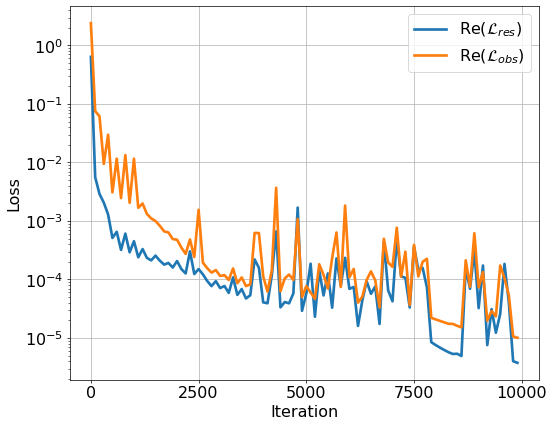

In [ ]:
# loss曲线
log = np.load(os.path.join(log_path, 'log.npy'), allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

itv_plot = 100
ax.plot(log["iter"][1::itv_plot], log["loss_res"][1::itv_plot], label=r"Re($\mathcal{L}_{res})$", linewidth=3)
ax.plot(log["iter"][1::itv_plot], log["loss_obs"][1::itv_plot], label=r"Re($\mathcal{L}_{obs})$", linewidth=3)
ax.set_yscale('log')
ax.set_xticks(np.linspace(0, log["iter"][-1]+1, 5))
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend(loc='upper right')
ax.grid()

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'Loss.png'), dpi=64, bbox_inches='tight')
plt.show()

In [ ]:
model_state = torch.load(os.path.join(model_path, 'model_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_param.load_state_dict(model_state['nn_param_state'])
pinn.eval();

In [ ]:
# 导入外部数据
data = pd.read_excel(os.path.join(data_path, '温度和热源.xlsx'), engine='openpyxl')
xx = np.array(data['水平方向'])
yy = np.array(data['垂直方向'])
T = np.array(data['温度'])
G = np.array(data['热源'])
K = 1.

In [ ]:
X = np.stack([xx, yy], axis=1)
X = torch.from_numpy(X).float().to(device)

T_pred = pinn.net_u(X)
T_pred = T_pred.detach().cpu().numpy().flatten()
T_error = np.linalg.norm(T_pred - T) / np.linalg.norm(T)
print('Relative l2 error of T: {:.3e}'.format(T_error))

G_pred = pinn.net_param(X)
G_pred = G_pred.detach().cpu().numpy().flatten()
G_error = np.linalg.norm(G_pred - G) / np.linalg.norm(G)
print('Relative l2 error of G: {:.3e}'.format(G_error))

with open(os.path.join(log_path, 'relative_error.txt'), 'w') as f_obj:
    f_obj.write('Relative l2 error of T: {:.3e}\n'.format(T_error))
    f_obj.write('Relative l2 error of G: {:.3e}\n'.format(G_error))

Relative l2 error of T: 3.955e-02
Relative l2 error of G: 2.352e-01


In [ ]:
xmin, xmax, ymin, ymax = domain

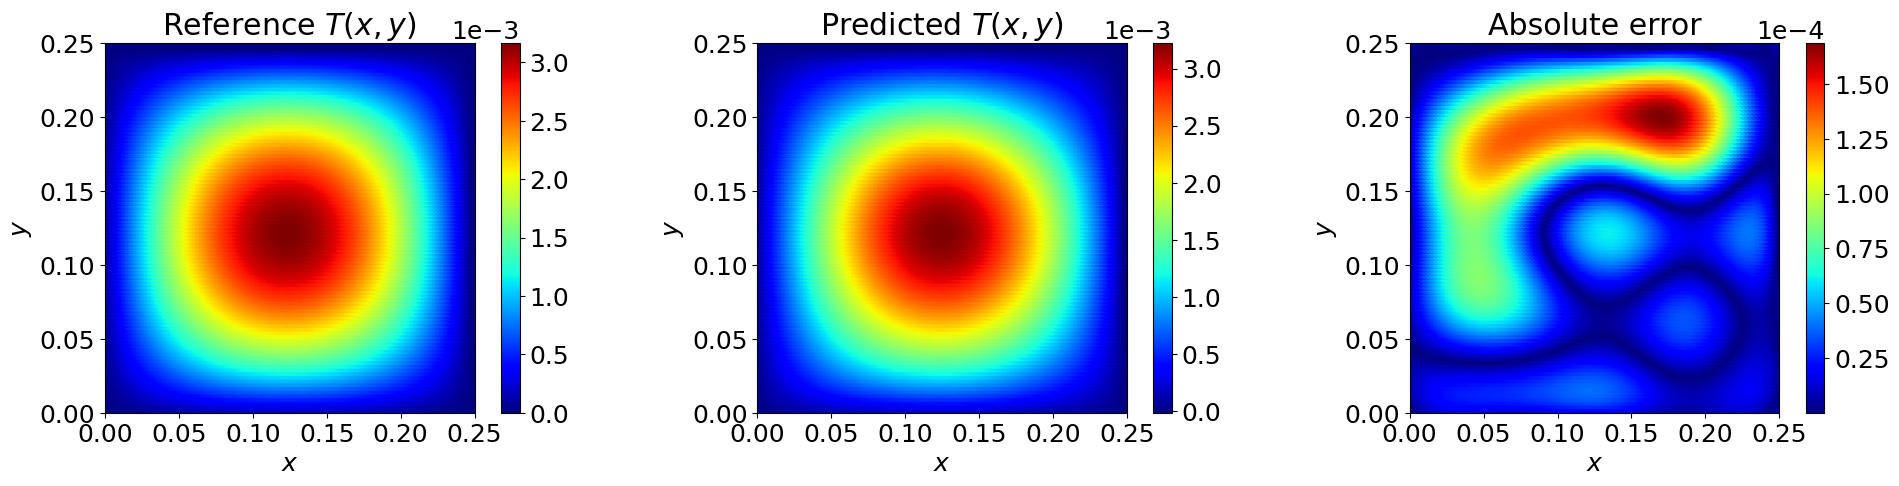

In [ ]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

ax = axes[0]
cax = ax.scatter(xx, yy, c=T, s=100, cmap='jet')
cbar = fig.colorbar(cax)
cbar.formatter.set_powerlimits((-3, -3))
cbar.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $T(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[1]
cax = ax.scatter(xx, yy, c=T_pred, s=100, cmap='jet')
cbar = fig.colorbar(cax)
cbar.formatter.set_powerlimits((-3, -3))
cbar.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Predicted $T(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[2]
cax = ax.scatter(xx, yy, c=abs(T - T_pred), s=100, cmap='jet')
cbar = fig.colorbar(cax)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Absolute error')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'T.png'), dpi=64, bbox_inches='tight')
plt.show()

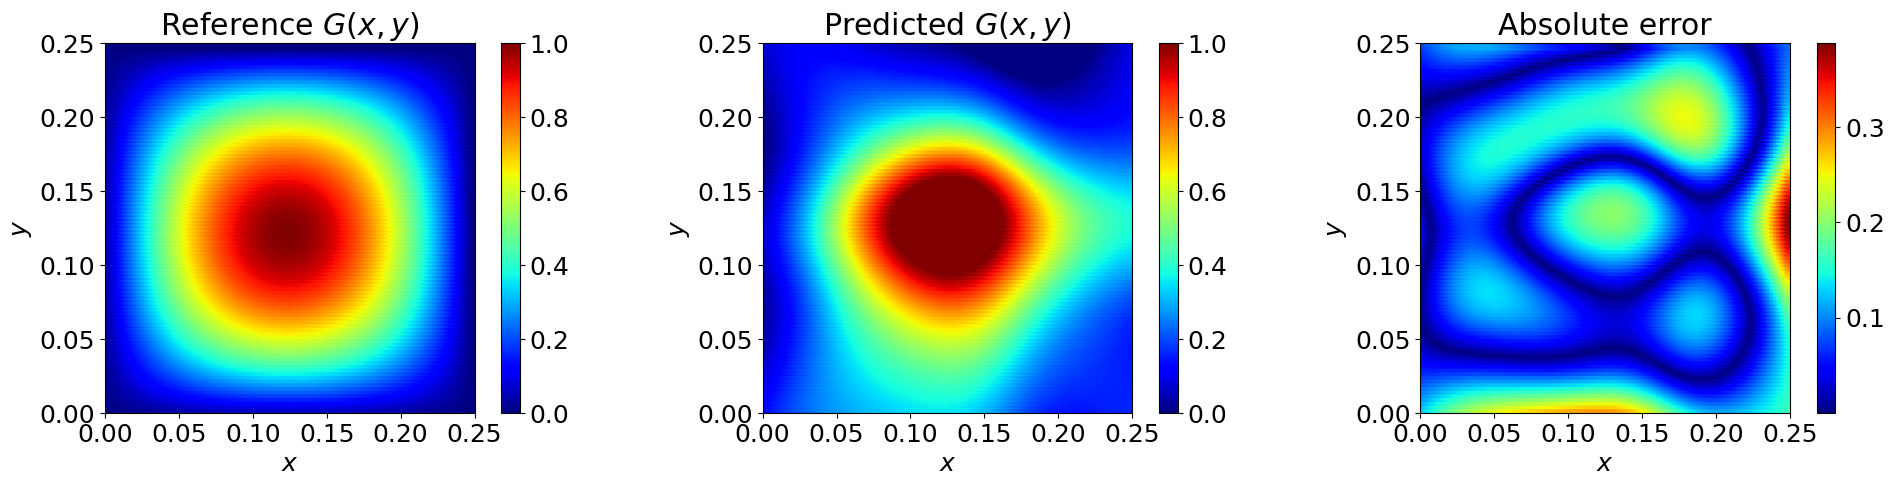

In [ ]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

ax = axes[0]
cax = ax.scatter(xx, yy, c=G, s=100, cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $G(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[1]
cax = ax.scatter(xx, yy, c=G_pred, s=100, cmap='jet', vmin=0., vmax=1.)
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Predicted $G(x,y)$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

ax = axes[2]
cax = ax.scatter(xx, yy, c=abs(G - G_pred), s=100, cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Absolute error')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 6))
ax.set_yticks(np.linspace(ymin, ymax, 6))
ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'G.png'), dpi=64, bbox_inches='tight')
plt.show()

In [ ]:
io.savemat(os.path.join(data_path, 'PoissonDiscovery.mat'),{
    'xx':xx,
    'yy':yy, 
    'T':T, 
    'G':G, 
    'T_pred':T_pred, 
    'G_pred':G_pred, 
})